In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

#make plots inline using jupyter magic
%matplotlib inline

import pandas as pd
from pandas.plotting import scatter_matrix
from sklearn import datasets, linear_model, metrics


import matplotlib as mpl
import seaborn as sns

import sklearn.linear_model as skl_lm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.neighbors import KNeighborsClassifier
#Balanced RF Classifier
from imblearn.ensemble import BalancedRandomForestClassifier as BRF

from IPython.display import Markdown as md  #enable markdown within code cell
from IPython.display import display, Math, Latex

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import confusion_matrix
import time

### Utility Functions

In [2]:
def get_data_path(data_name="none", 
                  data_file_name="project_dataset.csv"):
    """  Gets the data path, specific to the project configuration.
    
    :return path to data
    """
    
    proj_dirs = os.getcwd().split("code")
    data_dir = os.path.join(proj_dirs[0], "data")
    data_path = os.path.join(data_dir,data_file_name)
    
    return data_path
# Sample a given number of points from the provided dataset with replacement. seed for repeatability
def get_dataFrame_sample(subset_size, df, seed):
    return df.sample(n=subset_size, random_state=seed, replace=True)

# Sample a given number of points from the provided dataset. seed for repeatability
def get_dataFrame_subset(subset_size, df, seed):
    return df.sample(n=subset_size, random_state=seed)

### Pre-processing

In [3]:
file_name = get_data_path()
# usecols=['Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Flow Bytes/s', 'Label']
original_df = pd.read_csv(file_name, sep=',', encoding='utf-8', usecols=[' Flow Duration', ' Total Fwd Packets', 
                ' Total Backward Packets', ' Fwd Packet Length Mean', ' Bwd Packet Length Mean', 'Flow Bytes/s', 'Fwd Packets/s', ' Bwd Packets/s', ' Label']).dropna()
original_df = original_df.rename(columns={' Flow Duration':'flow_duration', ' Total Fwd Packets':'total_fwd_packets',
                                         ' Total Backward Packets':'total_bwd_packets', ' Fwd Packet Length Mean':'fwd_packet_length_mean',
                                         ' Bwd Packet Length Mean':'bwd_packet_length_mean', 'Flow Bytes/s':'flow_bytes/s',
                                         'Fwd Packets/s':'fwd_packets/s', ' Bwd Packets/s':'bwd_packets/s', ' Label':'label'})
# Remove leading/trailing whitespace




In [4]:
display(original_df.head())
display(original_df.describe())
display(original_df.info())

,flow_duration,total_fwd_packets,total_bwd_packets,fwd_packet_length_mean,bwd_packet_length_mean,flow_bytes/s,fwd_packets/s,bwd_packets/s,label
0,113095465,48,24,201.416667,417.166667,174.0122825,0.424420,0.212210,BENIGN
1,113473706,68,40,167.117647,317.950000,212.2253767,0.599258,0.352505,BENIGN
2,119945515,150,0,0.000000,0.000000,0,1.250568,0.000000,BENIGN
3,60261928,9,7,258.888889,603.000000,108.7087688,0.149348,0.116160,BENIGN
4,269,2,2,51.000000,161.000000,1576208.178,7434.944238,7434.944238,BENIGN


,flow_duration,total_fwd_packets,total_bwd_packets,fwd_packet_length_mean,bwd_packet_length_mean,fwd_packets/s,bwd_packets/s
count,1.703460e+05,170346.000000,170346.000000,170346.000000,170346.000000,1.703460e+05,1.703460e+05
mean,1.246500e+07,15.126231,18.024321,48.238913,160.141387,4.833884e+04,6.294574e+03
std,3.194011e+07,1123.173675,1494.580590,94.951956,274.427230,2.182801e+05,3.818158e+04
min,-1.000000e+00,1.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00
25%,1.920000e+02,1.000000,1.000000,8.093928,6.000000,5.037634e+00,2.276768e-01
50%,3.141400e+04,2.000000,2.000000,38.000000,79.000000,5.274864e+01,2.394346e+01
75%,8.195718e+05,4.000000,2.000000,50.000000,153.000000,1.025641e+04,4.705882e+03
max,1.200000e+08,200755.000000,270686.000000,4183.057143,3494.917198,3.000000e+06,2.000000e+06


<class 'pandas.core.frame.DataFrame'>
Int64Index: 170346 entries, 0 to 170365
Data columns (total 9 columns):
flow_duration             170346 non-null int64
total_fwd_packets         170346 non-null int64
total_bwd_packets         170346 non-null int64
fwd_packet_length_mean    170346 non-null float64
bwd_packet_length_mean    170346 non-null float64
flow_bytes/s              170346 non-null object
fwd_packets/s             170346 non-null float64
bwd_packets/s             170346 non-null float64
label                     170346 non-null object
dtypes: float64(4), int64(3), object(2)
memory usage: 13.0+ MB


None

### Data Distribution

In [176]:
benign = 'BENIGN'
benign_df = original_df[original_df['label'] == benign]
benign_df.label = 0
# Get number of malicious entries
malicious_df = original_df[original_df['label'] != benign]
malicious_df.label = 1
display(malicious_df.head())
display(malicious_df.describe())
"""
#Perform Class sampling with replacement to increase malicious sample size from 2000 to 10000 
malicious_df_resampled = get_dataFrame_sample(10000, malicious_df, 1)
display(malicious_df_resampled.head())
display(malicious_df_resampled.describe())
"""



display(benign_df.head())
display(benign_df.describe())

/home/mnewlin/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


,flow_duration,total_fwd_packets,total_bwd_packets,fwd_packet_length_mean,bwd_packet_length_mean,flow_bytes/s,fwd_packets/s,bwd_packets/s,label
12637,5185118,7,7,146.000000,331.571429,644.7297824,1.350017,1.350017,1
12643,5057374,10,7,73.600000,1411.428571,2099.113097,1.977311,1.384118,1
12700,81,1,1,0.000000,0.000000,0,12345.679010,12345.679010,1
12712,5271123,7,5,138.428571,286.000000,455.1212332,1.327990,0.948564,1
12791,5020638,7,4,139.000000,357.500000,478.6244298,1.394245,0.796711,1


,flow_duration,total_fwd_packets,total_bwd_packets,fwd_packet_length_mean,bwd_packet_length_mean,fwd_packets/s,bwd_packets/s,label
count,2.180000e+03,2180.000000,2180.000000,2180.000000,2180.000000,2180.000000,2180.000000,2180.0
mean,6.533719e+06,10.945413,5.281193,14.617832,47.825509,1707.982269,1430.930241,1.0
std,7.492580e+06,39.124039,20.156303,50.109359,211.114301,12215.370185,5918.297699,0.0
min,4.000000e+00,1.000000,0.000000,0.000000,0.000000,0.404235,0.000000,1.0
25%,5.177226e+06,3.000000,1.000000,0.000000,0.000000,0.523882,0.175406,1.0
50%,5.476074e+06,3.000000,1.000000,0.000000,0.000000,0.552916,0.185217,1.0
75%,5.783897e+06,3.000000,1.000000,0.000000,0.000000,0.585294,0.196237,1.0
max,7.020306e+07,212.000000,114.000000,241.305419,1773.202532,500000.000000,76923.076920,1.0


,flow_duration,total_fwd_packets,total_bwd_packets,fwd_packet_length_mean,bwd_packet_length_mean,flow_bytes/s,fwd_packets/s,bwd_packets/s,label
0,113095465,48,24,201.416667,417.166667,174.0122825,0.424420,0.212210,0
1,113473706,68,40,167.117647,317.950000,212.2253767,0.599258,0.352505,0
2,119945515,150,0,0.000000,0.000000,0,1.250568,0.000000,0
3,60261928,9,7,258.888889,603.000000,108.7087688,0.149348,0.116160,0
4,269,2,2,51.000000,161.000000,1576208.178,7434.944238,7434.944238,0


,flow_duration,total_fwd_packets,total_bwd_packets,fwd_packet_length_mean,bwd_packet_length_mean,fwd_packets/s,bwd_packets/s,label
count,1.681660e+05,168166.000000,168166.000000,168166.000000,168166.000000,1.681660e+05,1.681660e+05,168166.0
mean,1.254189e+07,15.180429,18.189515,48.674756,161.597381,4.894334e+04,6.357624e+03,0.0
std,3.212797e+07,1130.421466,1504.234404,95.317216,274.851647,2.196210e+05,3.841832e+04,0.0
min,-1.000000e+00,1.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.0
25%,1.900000e+02,1.000000,1.000000,13.750000,6.000000,6.282314e+00,2.437159e-01,0.0
50%,3.121500e+04,2.000000,2.000000,38.000000,81.000000,5.780765e+01,2.573274e+01,0.0
75%,4.912970e+05,4.000000,2.000000,50.000000,154.000000,1.035823e+04,5.050505e+03,0.0
max,1.200000e+08,200755.000000,270686.000000,4183.057143,3494.917198,3.000000e+06,2.000000e+06,0.0


In [177]:
# Concatenate benign and malicious and replace infinity with NaN and drop NaNs
actual_data = pd.concat([benign_df, malicious_df]).dropna()
actual_data = actual_data.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
actual_data = actual_data.astype(float, copy=True)
# Select finite data points
actual_data = actual_data[np.isfinite(actual_data).all(1)]
actual_y = actual_data.label
actual_data = actual_data.drop(['label'], axis=1)


# Train Test Split

In [178]:
# Train Test Split
test_ratio = 0.33
X_nonTest, X_test, y_nonTest, y_test = train_test_split(actual_data, actual_y, test_size=test_ratio, random_state=5)


# Scale Data

In [179]:
scaler = StandardScaler()
scaler.fit(X_nonTest)
X_nonTestScaled = scaler.transform(X_nonTest)  #non-test data scaled using non-test data mean and var
X_testScaled = scaler.transform(X_test)   #test data scaled using non-test data mean and var (prevents "learning" about the test set)

In [180]:
nonTest_df = pd.DataFrame(X_nonTestScaled, columns=actual_data.columns)
nonTest_df_unscaled = pd.DataFrame(X_nonTest, columns=actual_data.columns)
nonTest_df = pd.concat([nonTest_df, y_nonTest], axis=1)
nonTest_df_unscaled = pd.concat([nonTest_df_unscaled, y_nonTest], axis=1)
display(nonTest_df_unscaled.head())
display(nonTest_df_unscaled.describe())

,flow_duration,total_fwd_packets,total_bwd_packets,fwd_packet_length_mean,bwd_packet_length_mean,flow_bytes/s,fwd_packets/s,bwd_packets/s,label
11906,5752766.0,21.0,33.0,117.142857,992.909091,6123.315289,3.650418,5.736371,0.0
42960,76006.0,1.0,1.0,74.000000,156.000000,3026.076889,13.156856,13.156856,0.0
68846,23680.0,2.0,2.0,32.000000,93.000000,10557.432430,84.459459,84.459459,0.0
84703,771.0,1.0,1.0,0.000000,0.000000,0.000000,1297.016861,1297.016861,0.0
22680,30785.0,2.0,2.0,46.000000,85.000000,8510.638298,64.966705,64.966705,0.0


,flow_duration,total_fwd_packets,total_bwd_packets,fwd_packet_length_mean,bwd_packet_length_mean,flow_bytes/s,fwd_packets/s,bwd_packets/s,label
count,1.140540e+05,114054.000000,114054.00000,114054.000000,114054.000000,1.140540e+05,1.140540e+05,1.140540e+05,114054.000000
mean,1.252497e+07,17.394927,21.07329,48.441095,161.194514,1.858516e+06,4.866324e+04,6.247470e+03,0.012818
std,3.202022e+07,1250.342077,1661.76026,95.253818,276.502529,3.122389e+07,2.195341e+05,3.763610e+04,0.112491
min,-1.000000e+00,1.000000,0.00000,0.000000,0.000000,-2.610000e+08,0.000000e+00,0.000000e+00,0.000000
25%,1.920000e+02,1.000000,1.00000,9.282103,6.000000,1.569053e+02,5.072872e+00,2.281414e-01,0.000000
50%,3.145300e+04,2.000000,2.00000,38.000000,79.000000,4.834538e+03,5.293223e+01,2.377174e+01,0.000000
75%,8.527372e+05,4.000000,2.00000,50.000000,153.000000,2.790698e+05,1.030928e+04,4.694836e+03,0.000000
max,1.200000e+08,200755.000000,270686.00000,4183.057143,3494.917198,2.070000e+09,3.000000e+06,2.000000e+06,1.000000


# Scatterplots of Data Distributions

In [181]:
benign = 0
scatter_df_benign = nonTest_df_unscaled[nonTest_df_unscaled.label==benign].sample(frac=0.05, random_state=1)
scatter_df_malicious = nonTest_df_unscaled[nonTest_df_unscaled.label!=benign].sample(frac=0.05, random_state=1)
scatter_df = pd.concat([scatter_df_benign, scatter_df_malicious])

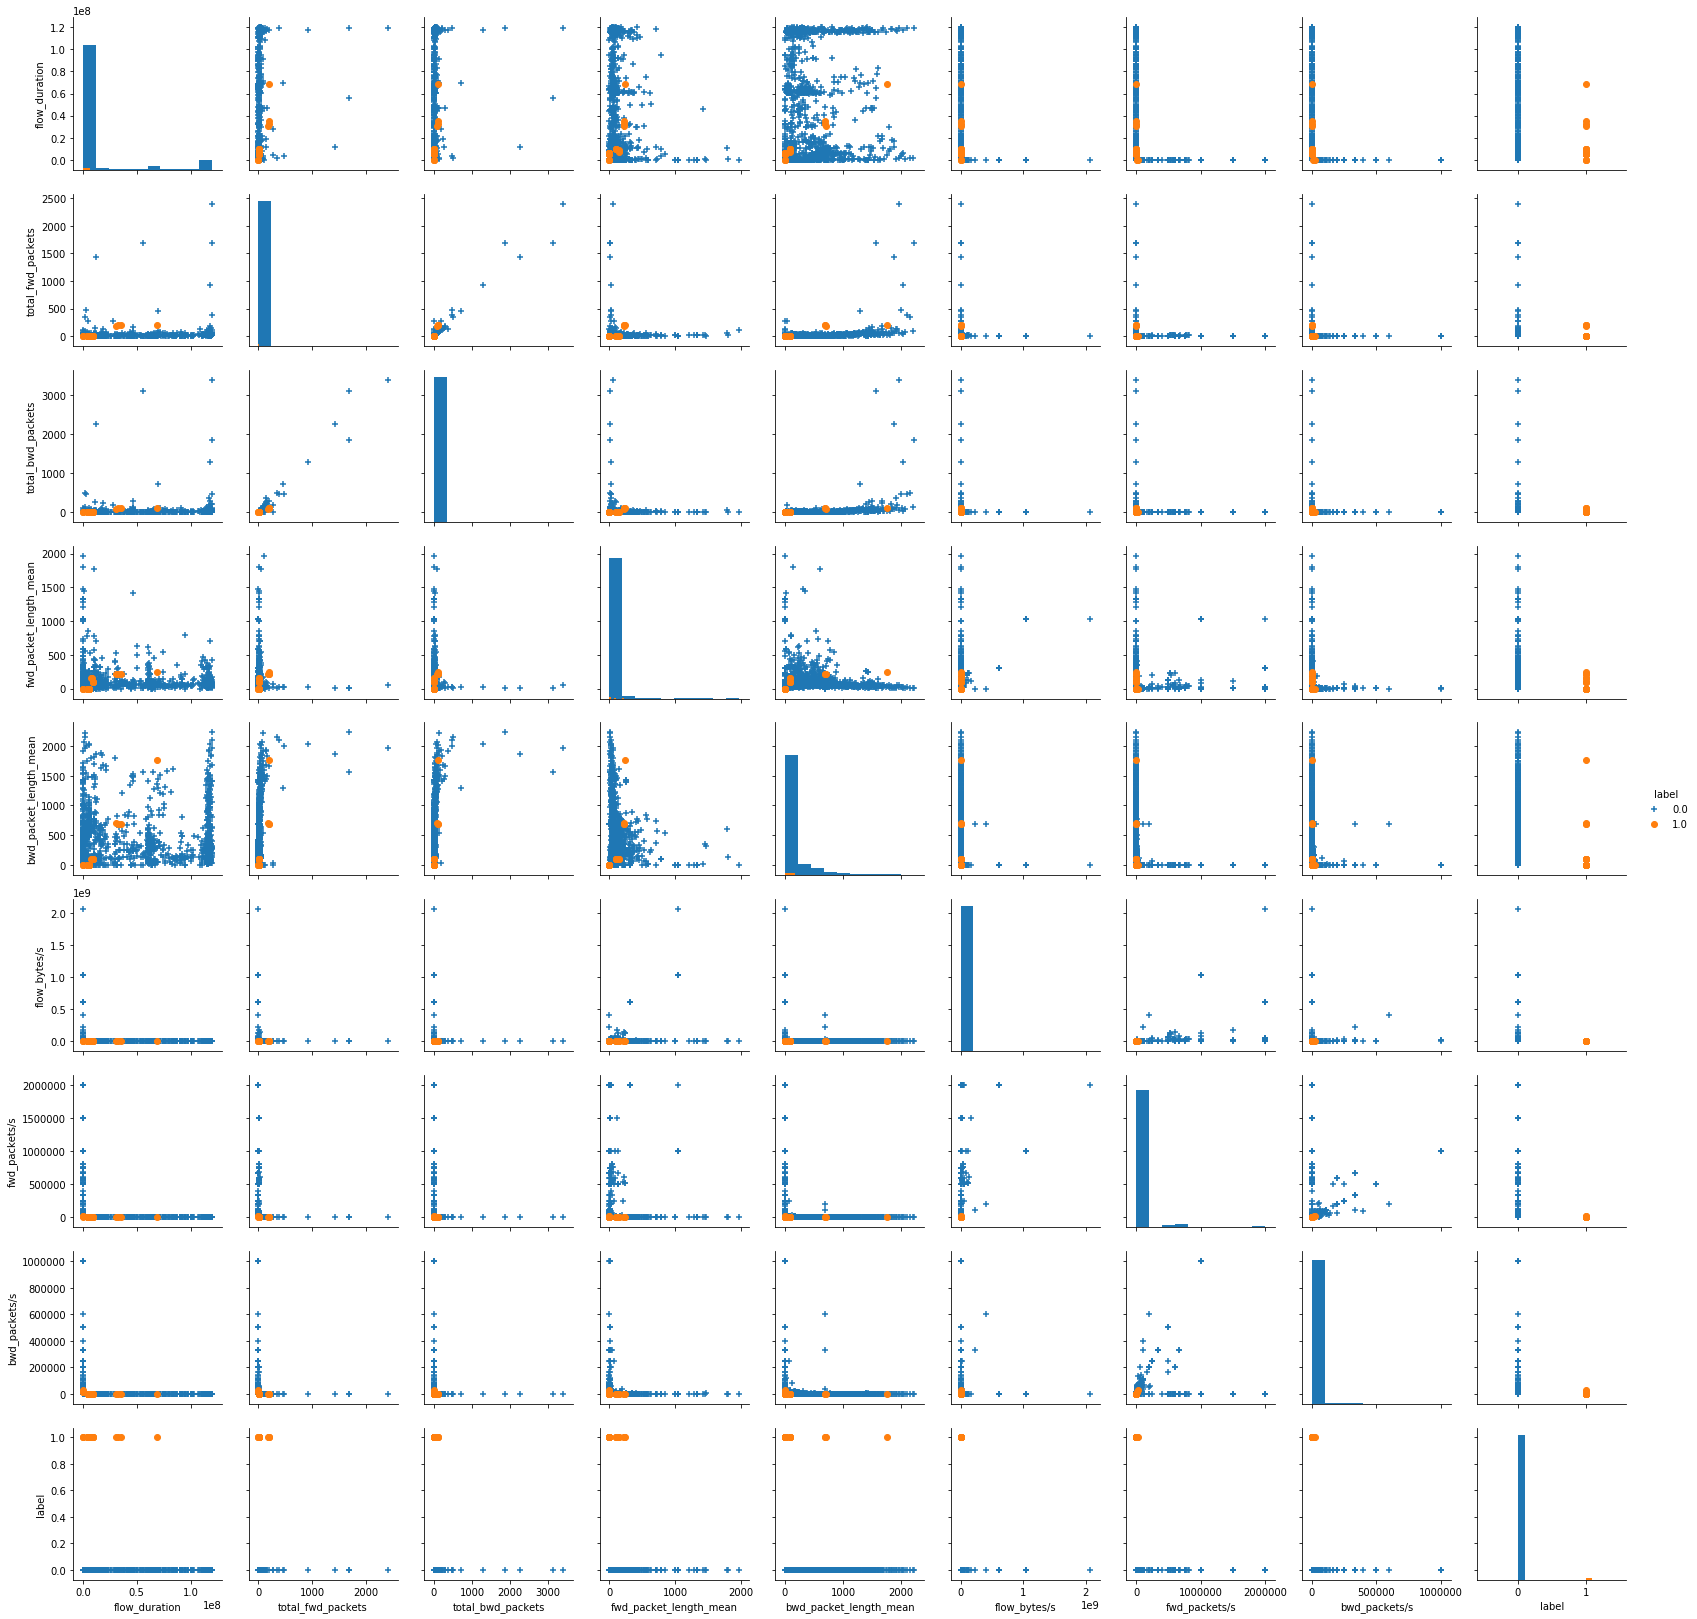

In [183]:
g = sns.PairGrid(scatter_df, hue="label", hue_kws={"marker": ["+", "o"]})
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)
g.add_legend();

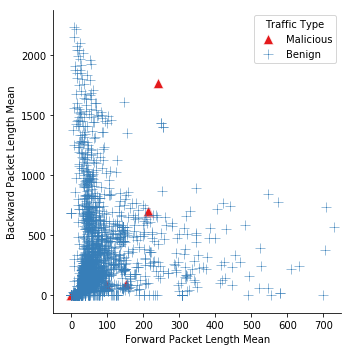

In [203]:
g = sns.FacetGrid(scatter_df, hue="label", palette="Set1", height=5, hue_order=[1,0], hue_kws={"marker": ["^", "+"]})
g.map(plt.scatter, "fwd_packet_length_mean", "bwd_packet_length_mean", s=100, linewidth=.5, edgecolor="white")
plt.xlabel("Forward Packet Length Mean")
plt.ylabel("Backward Packet Length Mean")
plt.xlim(-50,750)
plt.legend(title='Traffic Type', loc='upper right', labels=['Malicious', 'Benign'])
plt.savefig("../figures/scatter_means.eps")
plt.savefig("../figures/scatter_means.png")
plt.show(g)

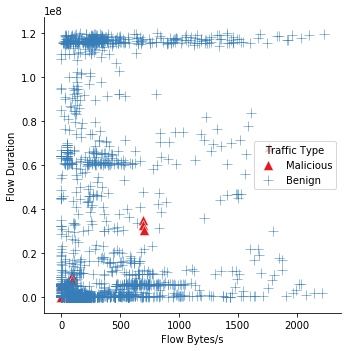

In [204]:
g = sns.FacetGrid(scatter_df, hue="label", palette="Set1", height=5,hue_order=[1,0], hue_kws={"marker": ["^", "+"]}, legend_out = True)
g.map(plt.scatter, "bwd_packet_length_mean", "flow_duration", s=100, linewidth=.5, edgecolor="white")

# replace labels
plt.xlabel("Flow Bytes/s")
plt.ylabel("Flow Duration")
plt.legend(title='Traffic Type', loc='center right', labels=['Malicious', 'Benign'])
plt.savefig("../figures/scatter_bytes_duration.eps")
plt.savefig("../figures/scatter_bytes_duration.png")
plt.show(g)

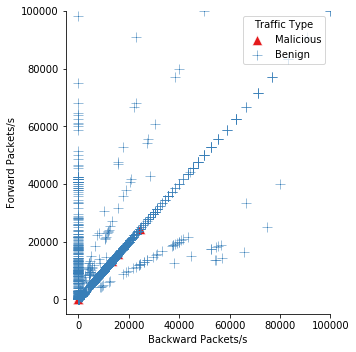

In [193]:
g = sns.FacetGrid(scatter_df, hue="label", palette="Set1", height=5, hue_order=[1,0], hue_kws={"marker": ["^", "+"]}, legend_out = True)
g.map(plt.scatter, "bwd_packets/s", "fwd_packets/s", s=100, linewidth=.5, edgecolor="white")

# replace labels
plt.xlabel("Backward Packets/s")
plt.ylabel("Forward Packets/s")
plt.xlim(-5000,100000)
plt.ylim(-5000,100000)
plt.legend(title='Traffic Type', loc='upper right', labels=['Malicious', 'Benign'])
#plt.savefig("../figures/scatter_backwardPack_forwardPack.eps")
plt.show(g)

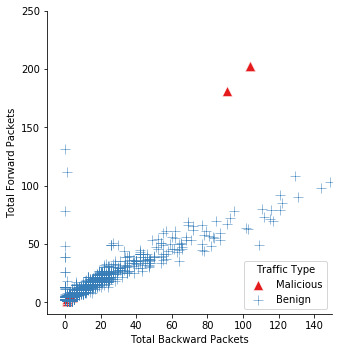

In [194]:
g = sns.FacetGrid(scatter_df, hue="label", palette="Set1", height=5, hue_order=[1,0], hue_kws={"marker": ["^", "+"]}, legend_out = True)
g.map(plt.scatter, "total_bwd_packets", "total_fwd_packets", s=100, linewidth=.5, edgecolor="white")

# replace labels
plt.xlabel("Total Backward Packets")
plt.ylabel("Total Forward Packets")
plt.xlim(-10,150)
plt.ylim(-10,250)
plt.legend(title='Traffic Type', loc='lower right', labels=['Malicious', 'Benign'])
plt.savefig("../figures/scatter_backwardPack_forwardPack.eps")
plt.savefig("../figures/scatter_backwardPack_forwardPack.png")
plt.show(g)

## Model Fitting - Cross Validation

### Logistic Regression

In [195]:
minalpha = 0.0001
maxalpha = 0.0025
# Cost vals for Logistic Regression, treated in LogR as inverse of regularization strength
cost_grid = np.linspace(minalpha, maxalpha,10)

lr_balanced_accs = []
start = time.time()
for cost in cost_grid:
    # Create logisitic regression with the cost parameter and l1 penalty for LASSO
    #
    log_reg = LogisticRegression(penalty='l1',class_weight='balanced',solver='saga',random_state=1, max_iter=1000,C=cost)

    #cross validate
    cross_val = cross_validate(log_reg,
                   X_nonTestScaled,
                   y_nonTest, 
                   cv=10,
                  scoring='balanced_accuracy')
    lr_balanced_accs.append(cross_val['test_score'].mean())
    print(cost)
end = time.time()

total = end - start
print("Total Time: ",total)

0.0001
0.00036666666666666667
0.0006333333333333334
0.0009000000000000001
0.0011666666666666668
0.0014333333333333336
0.0017000000000000001
0.0019666666666666665
0.0022333333333333333
0.0025
Total Time:  279.91477966308594


[0.667671405043462, 0.7578498276365201, 0.776486041386119, 0.7636256390295203, 0.7589421166361356, 0.752297354271646, 0.7479223476414323, 0.7433553354714701, 0.7403909134622306, 0.738326700899613]


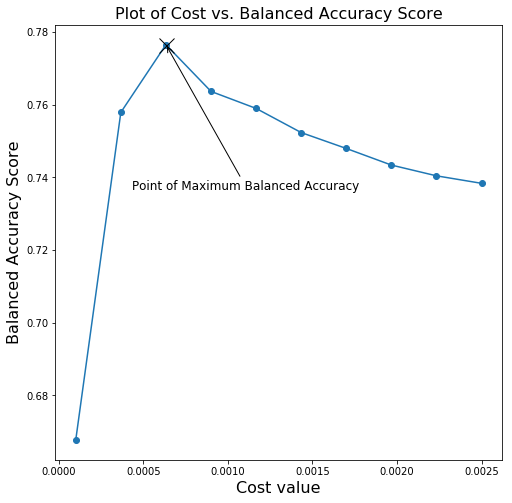

Best Cost 0.0006333333333333334
Max Balanced Accuracy 0.776486041386119


In [196]:
print(lr_balanced_accs)
best_bal_acc = np.max(lr_balanced_accs)
best_cost = cost_grid[np.argmax(lr_balanced_accs)]

fig = plt.figure(figsize=(8,8))
plt.plot(cost_grid,lr_balanced_accs, '-o')
plt.xlabel("Cost value", fontdict={'fontsize':16})
plt.ylabel("Balanced Accuracy Score", fontdict={'fontsize':16})
plt.title("Plot of Cost vs. Balanced Accuracy Score",  fontdict={'fontsize':16})
plt.plot(best_cost,best_bal_acc, marker = 'x',color='black',markersize=15)
plt.annotate('Point of Maximum Balanced Accuracy', xy=(best_cost,best_bal_acc), xytext=(best_cost-0.0002,best_bal_acc-.04), arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3", ec="black"), color='black', fontsize='large')
plt.savefig("../figures/lr_acc.eps")
plt.savefig("../figures/lr_acc.png")
plt.show()
print("Best Cost",best_cost)
print("Max Balanced Accuracy",best_bal_acc)

In [197]:
#Create Best LR model
best_log_reg = LogisticRegression(penalty='l1',class_weight='balanced',solver='saga',random_state=1, max_iter=1000,C=best_cost)

## K Nearest Neighbors

In [198]:
knn = None
knn_bal_acc = []
k_grid = np.arange(1,40+1,1)
start = time.time()
for k in k_grid:
    knn = KNeighborsClassifier(n_neighbors=k,weights='uniform',n_jobs=4)
    cross_val = cross_validate(knn,
                   X_nonTestScaled,
                   y_nonTest, 
                   cv=10,
                  scoring='balanced_accuracy')
    knn_bal_acc.append(cross_val['test_score'].mean())
    print(k)
end =  time.time()

total = end - start
print(total)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
1304.266445159912


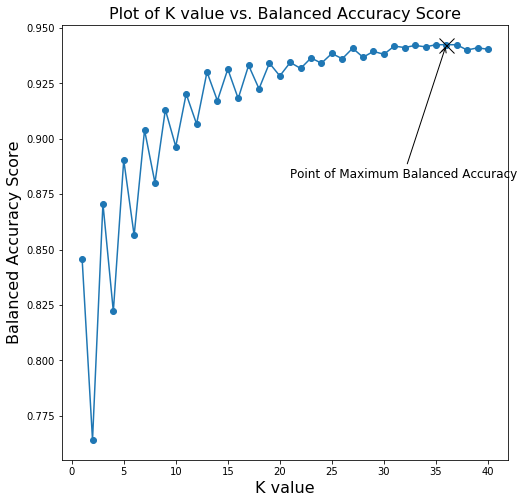

In [199]:
best_k = k_grid[np.argmax(knn_bal_acc)]
best_knn_bal_acc = np.max(knn_bal_acc)


fig = plt.figure(figsize=(8,8))
plt.plot(k_grid,knn_bal_acc, '-o')
plt.xlabel("K value", fontdict={'fontsize':16})
plt.ylabel("Balanced Accuracy Score", fontdict={'fontsize':16})
plt.title("Plot of K value vs. Balanced Accuracy Score",  fontdict={'fontsize':16})
plt.plot(best_k,best_knn_bal_acc, marker = 'x',color='black',markersize=15)
plt.annotate('Point of Maximum Balanced Accuracy', xy=(best_k,best_knn_bal_acc), xytext=(best_k-15,best_knn_bal_acc-.06), arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3", ec="black"), color='black', fontsize='large')
plt.savefig("../figures/knn_acc.eps")
plt.savefig("../figures/knn_acc.png")
plt.show()

## Balanced Random Forest

In [164]:
"""
    Performs balanced random forest classification with the given number of trees and returns
    mean balanced accuracy score from 10-fold cross validation.
"""
def find_num_estimators(n, d, p, X, y):
    brf = BRF(n_estimators=n,random_state=1, n_jobs=4, sampling_strategy=1.0,class_weight='balanced')
    cv = cross_validate(brf,
                   X,
                   y, 
                   cv=10,
                  scoring='balanced_accuracy',
                  n_jobs=4)
    return cv['test_score'].mean()
    

In [200]:
brf_bal_accs = [] #np.zeros((25,6))
num_trees = np.arange(100,1000+1,100)
start = time.time()
for n in num_trees:
    cv_ne_mean = find_num_estimators(n,d,3, X_nonTestScaled,y_nonTest)
    brf_bal_accs.append(cv_ne_mean)
    print(n)
end = time.time()
total = end - start
print(total)

100
200


/home/mnewlin/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/mnewlin/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/mnewlin/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


300
400
500
600
700
800
900
1000
433.4443075656891


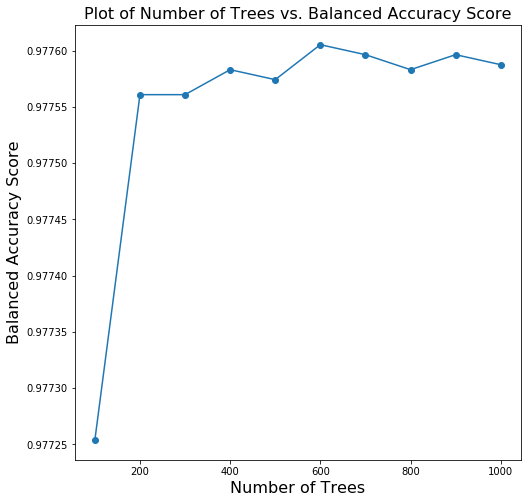

Number of Trees with highest Balanced Accuracy:  600


In [201]:
fig = plt.figure(figsize=(8,8))
plt.plot(num_trees,brf_bal_accs, '-o')
plt.xlabel("Number of Trees", fontdict={'fontsize':16})
plt.ylabel("Balanced Accuracy Score", fontdict={'fontsize':16})
plt.title("Plot of Number of Trees vs. Balanced Accuracy Score",  fontdict={'fontsize':16})
plt.savefig("../figures/num_trees_acc.eps")
plt.savefig("../figures/num_trees_acc.png")
plt.show()
best_num_trees = num_trees[np.argmax(brf_bal_accs)]
print("Number of Trees with highest Balanced Accuracy: ",best_num_trees)

### Tune max_features and max_depth

In [167]:
def find_depth_features(n, d, p, X, y):
    # Balanced Random Forest to sample to get 50/50 split between 1 and 0 class
    brf = BRF(n_estimators=n,max_depth=d, max_features=p, random_state=1, n_jobs=4,sampling_strategy=1.0, class_weight='balanced')
    cv = cross_validate(brf,
                   X,
                   y, 
                   cv=10,
                  scoring='balanced_accuracy',
                  n_jobs=4)
    return cv['test_score'].mean()

In [202]:

depths = np.arange(1,30+1,1)
features = np.arange(1,5+1,1)
hp_bal_accs = np.zeros((len(depths),len(features)))
start = time.time()
for d in range(len(depths)):
    for p in range(len(features)):
        cv_ne_mean = find_depth_features(best_num_trees,d+1,p+1, X_nonTestScaled,y_nonTest)
        hp_bal_accs[d,p] = cv_ne_mean
    print(d)
end = time.time()
print(end - start)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
7342.41765666008


Max Depth: 19
Max Features: 2


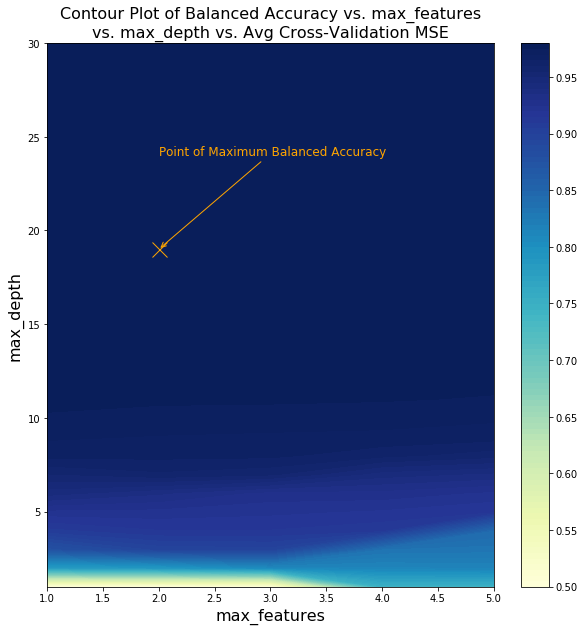

In [209]:
from textwrap import wrap
fig_contour = plt.figure(figsize=(10,10))
ax = plt.contourf(features, depths, hp_bal_accs,levels=100, cmap='YlGnBu')
cbar = fig_contour.colorbar(ax)
min_inds = np.unravel_index(np.argmax(hp_bal_accs, axis=None), hp_bal_accs.shape)
print("Max Depth: {}".format(min_inds[0]+1))
print("Max Features: {}".format(min_inds[1]+1))
plt.xlabel("max_features",fontdict={'fontsize':16})
plt.ylabel("max_depth",fontdict={'fontsize':16})
plt.title('\n'.join(wrap("Contour Plot of Balanced Accuracy vs. max_features vs. max_depth vs. Avg Cross-Validation MSE",50)), fontsize=16)
plt.plot(min_inds[1]+1,min_inds[0]+1,marker='x',color='orange', markersize=15)
plt.annotate('Point of Maximum Balanced Accuracy', xy=(min_inds[1]+1,min_inds[0]+1), xytext=(min_inds[1]+1,min_inds[0]+6), arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3", ec="orange"), color='orange', fontsize='large')
plt.savefig('../figures/countour_bal_acc.eps')
plt.savefig('../figures/countour_bal_acc.png')
plt.show()

In [210]:
m_depth=min_inds[0]+1
m_features=min_inds[1]+1

## Create best 3 models and cross validate

In [222]:
best_log_reg = LogisticRegression(penalty='l1',class_weight='balanced',solver='saga',random_state=1, max_iter=1000,C=best_cost)
best_knn = KNeighborsClassifier(n_neighbors=k,weights='uniform')
best_brf = BRF(n_estimators=best_num_trees, max_depth=m_depth,max_features=m_features, random_state=1, 
               sampling_strategy='not majority', class_weight='balanced', replacement=True)

cross_val_brf = cross_validate(best_brf,
                           X_nonTestScaled,
                           y_nonTest,
                           cv=10,
                          scoring='balanced_accuracy')

cross_val_knn = cross_validate(best_knn,
                           X_nonTestScaled,
                           y_nonTest,
                           cv=10,
                          scoring='balanced_accuracy')

cross_val_log_reg = cross_validate(best_log_reg,
                           X_nonTestScaled,
                           y_nonTest,
                           cv=10,
                          scoring='balanced_accuracy')

knn_bal_accs = cross_val_knn['test_score']
log_reg_bal_accs = cross_val_log_reg['test_score']
brf_bal_accs = cross_val_brf['test_score']

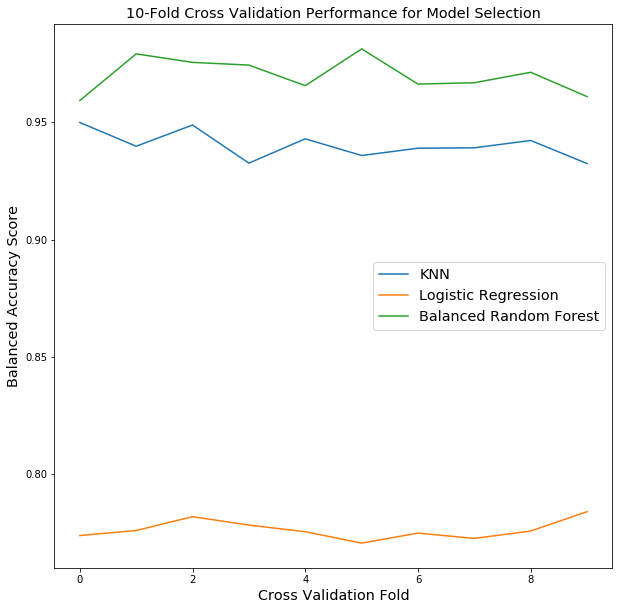

In [223]:
# Plot Model Cross Val Results
model_fig = plt.figure(figsize=(10,10))
plt.plot(knn_bal_accs)
plt.plot(log_reg_bal_accs)
plt.plot(brf_bal_accs)
plt.legend(['KNN', 'Logistic Regression','Balanced Random Forest'], fontsize='x-large')
plt.title("10-Fold Cross Validation Performance for Model Selection", fontsize='x-large')
plt.xlabel("Cross Validation Fold", fontsize='x-large')
plt.ylabel("Balanced Accuracy Score", fontsize='x-large')
plt.savefig("../figures/model_eval.eps")
plt.savefig("../figures/model_eval.png")
plt.show()

In [224]:
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, precision_recall_curve
from sklearn.metrics import precision_recall_curve as PRC
# Fit Best BRF Model on all nonTest data
best_brf.fit(X_nonTestScaled, y_nonTest)
y_test = np.array(y_test)
# Predict on Test Set
X_test = np.array(X_test)
y_pred = best_brf.predict(X_test)
y_pred_prob = best_brf.predict_proba(X_test)

In [ ]:
def getPRdata(truthVals,probs,thresholds):
    num_samples = len(thresholds)
    pr_data_columns = ['prob_threshold', 'TP_count', 'FP_count', 'TN_count', 'FN_count', 'TP_rate',
                       'FP_rate', 'accuracy', 'precision', 'F-measure']
    pr_data_df = pd.DataFrame(np.zeros((num_samples, len(pr_data_columns)), dtype=float),
                               columns = pr_data_columns)
    
    # calculate values
    curr_entry = []  
    position = 0
    for curr_prob in thresholds:
        # Variables
        tp_count = 0
        fp_count = 0
        tn_count = 0
        fn_count = 0
        tp_rate = 0.
        fp_rate = 0.
        accuracy = 0.
        precision = 0.
        f_measure = 0.
        predict_prob = 0.0
        #end variable declarations
        counter = 0
        for val in truthVals:
            predict_prob = probs[counter]
            if (val == 0):
                if(predict_prob >= curr_prob):
                    fp_count += 1 #Truth val neg, predict pos: false positive
                else:
                    tn_count += 1 #Truth val neg, predict neg: true negative 
            else:
                if(predict_prob >= curr_prob):
                    tp_count += 1 # truth val positive, predict pos: true positive
                else:
                    fn_count += 1 # truth val positive, predict neg: false negative
            counter += 1
         #End for
        tp_rate = tp_count/(tp_count + fn_count)
        fp_rate = fp_count/(tn_count + fp_count)
        accuracy = (tn_count + tp_count)/(tp_count + tn_count + fp_count + fn_count)
        precision = tp_count/(tp_count + fp_count)
        f_measure = (2*tp_rate*precision)/(precision + tp_rate)
    
        # Add values to dataframe
        pr_data_df.at[position, 'prob_threshold'] = curr_prob
        pr_data_df.at[position, 'TP_count'] = tp_count
        pr_data_df.at[position, 'FP_count'] = fp_count
        pr_data_df.at[position, 'TN_count'] = tn_count
        pr_data_df.at[position, 'FN_count'] = fn_count
        pr_data_df.at[position, 'TP_rate'] = tp_rate
        pr_data_df.at[position, 'FP_rate'] = fp_rate
        pr_data_df.at[position, 'accuracy'] = accuracy
        pr_data_df.at[position, 'precision'] = precision
        pr_data_df.at[position, 'F-measure'] = f_measure
        
        position += 1
    #End for  
    return pr_data_df

In [225]:
print(y_test_np[:5])
print(y_pred_prob[:5])
print(len(y_test) - np.count_nonzero(y_test))
print(len(y_pred) - np.count_nonzero(y_pred))

#balanced_accuracy = balanced_accuracy_score(y_test,y_pred)
prec,rec,_ = precision_recall_curve(y_test_np,y_pred_prob[:,1], pos_label=1)

#precision,recall,thresholds = PRC(y_test,y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
prec_score = precision_score(y_test,y_pred, average='weighted')
rec_score = recall_score(y_test,y_pred, average='weighted')

print("TN: ",tn)
print("FP: ",fp)
print("FN: ",fn)
print("TP: ",tp)

[1. 1. 1. 1. 1.]
[[0.86740712 0.13259288]
 [0.86740712 0.13259288]
 [0.86740712 0.13259288]
 [0.86740712 0.13259288]
 [0.83420408 0.16579592]]
55459
56177
TN:  55459
FP:  0
FN:  718
TP:  0


/home/mnewlin/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


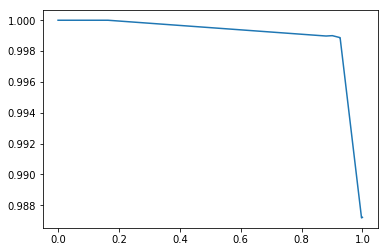

In [226]:
plt.plot(rec,prec)

In [221]:
print("Precision: ",prec_score)
print("Recall: ",rec_score)

Precision:  0.9746012919973113
Recall:  0.9872189686170497


In [62]:
bal_acc_cross_val_brf = cross_val_brf['test_balanced_accuracy']
f1_w_cross_val_brf = cross_val_brf['test_f1_weighted']
prec_cross_val_brf = cross_val_brf['test_precision_weighted']
recall_cross_val_brf = cross_val_brf['test_recall_weighted']

[0.97888106 0.98388099 0.97654175 0.9784121  0.98120986 0.97782961
 0.97138514 0.97311709 0.97751875 0.98103222]
[0.97470243 0.97670792 0.97599012 0.97419577 0.97757722 0.97755665
 0.97383815 0.97591606 0.97717674 0.97735995]


## SVM